## Kernels in GPFA
In this notebook we analyze the new kernels built in GPFA by running it on a public neuroscience dataset collected in salamander's ganglion cell.
Original GPFA framework attached with rbf kernel was developed by Byron Yu et al. (2009), its python version was implemented in Elephant python package. Its modified version with new kernels add-on are imported here and can be installed via executing command `pip install -e.` in elephant_modified directory.
Performance of each kernel can be benchmarked by data log-likelihood returned by GPFA model.

The function below loads 1 experiment from given neuroscience datasets.

In [13]:
%%time
import os
import numpy as np
import pandas as pd
import quantities as pq
import scipy.io as sio
import neo
from elephant.gpfa import GPFA
import viziphant
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
%matplotlib widget
import pickle

from threading import Lock
lock = Lock()

import warnings

def load_spikeTrains(raw_matrix, t_stop, t_start = 0):
    """
    Convert the spike trains from matrix extracted from .mat file to a matrix of neo.SpikeTrain
    Parameters
    ----------
    raw_matrix :  np.ndarray
        Matrix with num_of_trails row and num_of_neurons column, each cell of the matrix containing a 1D spike train
    t_stop : int
        Time of the left edge of the spike train (left extreme; included).
    t_start : int
         Time of the right edge of the spike train (right extreme; excluded).

    Returns
    -------
    spikeTrain_matrix : list of list of neo.SpikeTrain

    """

    spikeTrain_matrix = []

    for Trail_idx in range(len(raw_matrix)):
        Trail = []
        for Neuron_idx in range(len(raw_matrix[Trail_idx])):

            if np.size(raw_matrix[Trail_idx][Neuron_idx]) == 0:
                Trail.append(neo.SpikeTrain(np.array([])*pq.ms,axis=1*pq.ms,t_stop=t_stop*pq.ms))
            else:
                Trail.append(neo.SpikeTrain(np.squeeze(np.array(raw_matrix[Trail_idx][Neuron_idx]),axis=1)*pq.ms,
                                            axis=1*pq.ms,t_start = t_start*pq.ms,t_stop=t_stop*pq.ms))
        spikeTrain_matrix.append(Trail)

    return spikeTrain_matrix

Wall time: 2 ms


Here we analyze NaturalImages1 dataset, it is collected from salamander's ganglion cells when it is watching 60 natural images.
Load NaturalImages1 dataset and checkout its details.

In [14]:
data_set = "NaturalImages1"
raw_matrices = sio.loadmat("Spikes/"+data_set+".mat")
print("This dataset have {} Experiments".format(raw_matrices.get("Spikes").shape))
list_of_Experiments = raw_matrices.get("Spikes")
print("Each Experiment is repetitively conducted for {} trails, involving {} neurons"
      .format(list_of_Experiments[0][0].shape[1],list_of_Experiments[0][0].shape[0]))

This dataset have (60, 1) Experiments
Each Experiment is repetitively conducted for 30 trails, involving 38 neurons


## 1. Compare rbf kernel and best performed SM kernel
A series of kernels have been developed and tried out on the public dataset, in which SM kernel has a higher data log-likelihood than rbf kernel with visibly more informative latent trajectories extracted.
All new developed kernels's kernel parameters are currently optimised by gradient-free optimisers with choice of Bayesian Optimisation and Powell method in `Scipy.optimizer.minimizer` which can be selected via new GPFA parameter `bo`. Therefore, new kernels are temporarily has higher computation complexity due to its kernel optimisation strategy and natually more kernel parameters than rbf kernel.
### 1.1. Using rbf Kernel
Extract the 3D Latent trajectories of the first experiment of dataset using GPFA default rbf kernel.
Plot latent trajecories by viziphant (elephant sister visualization package) `gpfa.plot_trajectories` function.
Each line in the graph represents single trail latent trajectory.

c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '


Initializing parameters using factor analysis...

Fitting GPFA model...
3998.803697025299
Wall time: 5.03 s


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


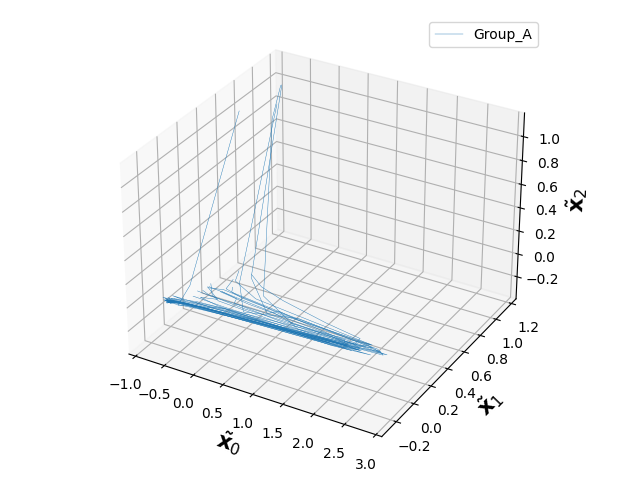

In [15]:
%%time
# For compute efficiency, train on equal-length segments of trials, ignore warning message if trails are not long enough to be segmented to save computations.
warnings.filterwarnings(action='ignore',message='^trial corresponding to index')
spikeTrains_1 = load_spikeTrains(list_of_Experiments[0][0].T,300)
bin_size = 20 * pq.ms
latent_dimensionality = 3
gpfa_3dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality,covType='rbf')
gpfa_3dim.fit(spikeTrains_1)
trajectories = gpfa_3dim.transform(spikeTrains_1)
viziphant.gpfa.plot_trajectories(trajectories,gpfa_3dim,dimensions=list(range(latent_dimensionality)),trial_grouping_dict = {'Group_A':list(range(len(spikeTrains_1[0])))},plot_group_averages=False,plot_args_single={'alpha': 1, 'linestyle': '-', 'linewidth': 0.3}, plot_args_marker={'alpha': 1, 'markersize': 100})
print(gpfa_3dim.fit_info["log_likelihoods"][-1])

## 1.2. Using SM kernel
Extract the 3D Latent trajectories of the same experiment using Spectral Mixture kernel with pre-set 2 Spectral Mixtures.
We can see the data log-likelihood slightly raises, while more time is consumed in running.
The latent trajectories has more variabilities in $\tilde{\mathbf{x}}_2$ (latent dimension 2) and more rigid (less smoother) than the one extracted in rbf kernel setting.

c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '


Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 45 EM iterations.)
w[0]: [0.55417254 0.40838162]
mu[0]: [0.92399669 0.99996253]
vs[0]: [5.80836840e-05 1.64927486e-01]
w[1]: [0.99996578 0.44438732]
mu[1]: [0.99995338 0.98312102]
vs[1]: [0.11439777 0.17443905]
w[2]: [0.22050923 0.86156384]
mu[2]: [0.75101036 0.84554478]
vs[2]: [0.24017709 0.05805455]
4058.1404553523244
Wall time: 30.4 s


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


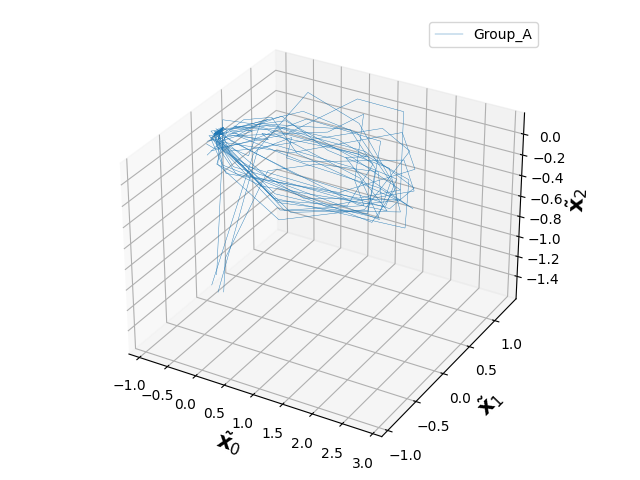

In [16]:
%%time
gpfa_3dim_sm = GPFA(bin_size=bin_size, x_dim=latent_dimensionality,covType='sm')
gpfa_3dim_sm.fit(spikeTrains_1)
trajectories = gpfa_3dim_sm.transform(spikeTrains_1)
viziphant.gpfa.plot_trajectories(trajectories,gpfa_3dim_sm,dimensions=list(range(latent_dimensionality)),trial_grouping_dict = {'Group_A':list(range(len(spikeTrains_1[0])))},plot_group_averages=False,plot_args_single={'alpha': 1, 'linestyle': '-', 'linewidth': 0.3}, plot_args_marker={'alpha': 1, 'markersize': 20})
print(gpfa_3dim_sm.fit_info["log_likelihoods"][-1])

## 2. Color latent trajectory to emphasize temporal order
GPFA is a time series model, each point in a latent trajectory represents a neural state at a specific time-bin.
Viziphant `gpfa.plot_trajectories` function is mainly targeting the shape of latent trajectories and ignores the direction and distance between each state.
A better visualization function is developed to emphasize the temporal order between states by gradient coloring single trail trajectories.

In [17]:


def plot_trajectories_vs_time(spikeTrain_matrix,
                         GPFA_kargs = {'x_dim':3, 'bin_size': 20 *pq.ms, 'covType' : 'rbf', 'bo': False},
                         dimensions=[0, 1, 2],
                         orthonormalized_dimensions=True,
                         n_trials_to_plot = 30,
                         plot_average=True,
                         gradient_color_bar = False,
                         plot_args_single={'linewidth': 0.5,
                                           'alpha': 1,
                                           'linestyle': '-'},
                         plot_args_average={'linewidth': 2,
                                            'alpha': 1,
                                            'linestyle': '-',
                                            'color' : 'C1'},
                         figure_kargs=dict(figsize=(7.5, 7))):
    '''
    Plot latent 2D or 3D trajectories of a spike train matrix with color gradient to emphasizing temporal sequence in every single trajectory.
    Line segments from start to end between each neural state are mapped with gradient color in colormap plt.cm.jet .
    Parameters
    ----------
    spikeTrain_matrix : list of list of neo.SpikeTrain
        Spike train data to be fit to latent variables.
    GPFA_kargs : dict
        Arguments dictionary passed to GPFA
    dimensions : list of int
        Dimensions to plot.
    orthonormalized_dimensions : bool
        Boolean which specifies whether to plot the orthonormalized latent
        state space dimension corresponding to the entry 'latent_variable_orth'
        in returned data (True) or the unconstrained dimension corresponding
        to the entry 'latent_variable' (False).
        Beware that the unconstrained state space dimensions 'latent_variable'
        are not ordered by their explained variance. These dimensions each
        represent one Gaussian process timescale $\tau$.
        On the contrary, the orthonormalized dimensions 'latent_variable_orth'
        are ordered by decreasing explained variance, allowing a similar
        intuitive interpretation to the dimensions obtained in a PCA. Due to
        the orthonormalization, these dimensions reflect mixtures of
        timescales.
    n_trials_to_plot : int, optional
        Number of single trial trajectories to plot.
    plot_average : bool
        If True, trajectories are averaged and plotted.
    gradient_color_bar : bool
        If true, plot the color bar in gradient color, used when too much time bins to show in color bar.
        If false, plot the color bar in discrete intervals, color of each interval matches a line segment between each neural state.
    plot_args_single : dict
        Arguments dictionary passed to ax.plot() of the single trajectories.
    plot_args_average : dict
        Arguments dictionary passed to ax.plot() of the average trajectories.
    figure_kwargs : dict
        Arguments dictionary passed to ``plt.figure()``.

    Returns
    -------
    loglikelihood : float
        Data log-likelihood using GPFA to extract latent trajectories to 3 dimensions
    f : matplotlib.figure.Figure
    ax1 : matplotlib.axes.Axes

    ax2 : matplotlib.axes.Axes
    '''

    gpfa_3dim = GPFA(**GPFA_kargs)
    gpfa_3dim.fit(spikeTrain_matrix)
    returned_data = gpfa_3dim.transform(spikeTrain_matrix, returned_data=['latent_variable_orth','latent_variable'])
    log_likelihood = gpfa_3dim.fit_info["log_likelihoods"][-1]

    trajectories = viziphant.gpfa._check_input_data(returned_data, orthonormalized_dimensions)
    projection, n_dimensions = viziphant.gpfa._check_dimensions(gpfa_3dim,dimensions)

    lock.acquire()
    f = plt.figure(**figure_kargs)
    # partition the geometry into equally spaced 13 columns
    gs = f.add_gridspec(1,13)
    # place latent trajectory plot at the first 12 columns space and the color bar at the last column
    ax1 = f.add_subplot(gs[0,:-2],projection=projection)
    ax2 = f.add_subplot(gs[0,-1])

    ax1.set_title(gpfa_3dim.covType+' with LL '+str(round(log_likelihood,2)),fontsize=30)

    # single trial trajectories
    n_trials = trajectories.shape[0]
    for trail_idx in range(min(n_trials, n_trials_to_plot)):
        single_trial_trajectory = trajectories[trail_idx][dimensions, :]
        colour_map = np.linspace(0,len(single_trial_trajectory[0]),num=len(single_trial_trajectory[0])-1)
        colour_map_min = colour_map.min()
        colour_map_max = colour_map.max()

        for i in range(len(single_trial_trajectory[0])-1):
            if n_dimensions == 2:
                ax1.plot(single_trial_trajectory[0][i:i+2],single_trial_trajectory[1][i:i+2],
                color= plt.cm.jet(int((np.array(colour_map[i])-colour_map_min)*255/(colour_map_max-colour_map_min))),**plot_args_single)
            if n_dimensions == 3:
                # map each line segment (the line between each neural state) of a single trail trajectory with a gradient color in matplotlib.cm.jet color bar
                ax1.plot(single_trial_trajectory[0][i:i+2],single_trial_trajectory[1][i:i+2],single_trial_trajectory[2][i:i+2],
                color= plt.cm.jet(int((np.array(colour_map[i])-colour_map_min)*255/(colour_map_max-colour_map_min))),**plot_args_single)

    average_trajectory = np.mean(trajectories, axis=0)
    if plot_average:
        if n_dimensions == 2:
            ax1.plot(average_trajectory[0], average_trajectory[1], label='Trial averaged trajectory',**plot_args_average)
        if n_dimensions == 3:
            ax1.plot(average_trajectory[0], average_trajectory[1], average_trajectory[2], label='Trial averaged trajectory',**plot_args_average)
        ax1.legend(fontsize=18)
    # ax1.view_init(azim=-5, elev=60)  # pre-set viewing angle for the trajectory
    viziphant.gpfa._set_axis_labels_trajectories(ax1,orthonormalized_dimensions,dimensions)
    # set up color bar
    cmap = mpl.colors.ListedColormap(plt.cm.jet((np.linspace(0,1,len(trajectories[0][0])-1)*255).astype(int)))
    if gradient_color_bar:
        cb = mpl.colorbar.ColorbarBase(ax2, cmap=plt.cm.jet, ticks = [0,1])
        bounds = [1,len(trajectories[0][0])]
        cb.set_ticklabels(bounds,fontsize=15)
    else:
        # set up discrete color bar
        bounds = list(range(1,len(trajectories[0][0])+1))
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
                                    norm=norm,
                                    boundaries= bounds,
                                    # extend='both',
                                    ticks=bounds,
                                    # spacing='proportional',
                                    orientation='vertical')
        cb.set_ticklabels(bounds,fontsize=15)
    cb.set_label('time bin '+str(int(gpfa_3dim.bin_size.magnitude))+'ms',fontsize=15)
    plt.tight_layout()
    del spikeTrain_matrix,gpfa_3dim,trajectories,colour_map,colour_map_max,colour_map_min,average_trajectory
    lock.release()
    return log_likelihood, f, ax1, ax2

In [18]:
log_likelihood,f,ax1,ax2=plot_trajectories_vs_time(spikeTrains_1,GPFA_kargs = {'x_dim':3, 'bin_size': 20 *pq.ms, 'covType' : 'rbf', 'bo': False},
                         dimensions=[0, 1, 2], orthonormalized_dimensions=True, n_trials_to_plot = 30,plot_average=False,gradient_color_bar=False)
fig_path = 'LatentTrajectories/NaturalImages1/rbf/'
fig_name = '0_3d'
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
f.savefig(fig_path+fig_name+'.png')
pickle_file = open(fig_path+"/"+fig_name+'_Object.fig.pickle','wb')
pickle.dump(f,pickle_file)
pickle_file.close()
plt.close(f)

c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '


Initializing parameters using factor analysis...

Fitting GPFA model...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


Extracting large amount of neuroscience data in parallel will require us to store these plotting results in local.
In order to store 3D trajectories and make it to be easily rechecked, we use pickle to serialize matplotlib objects.

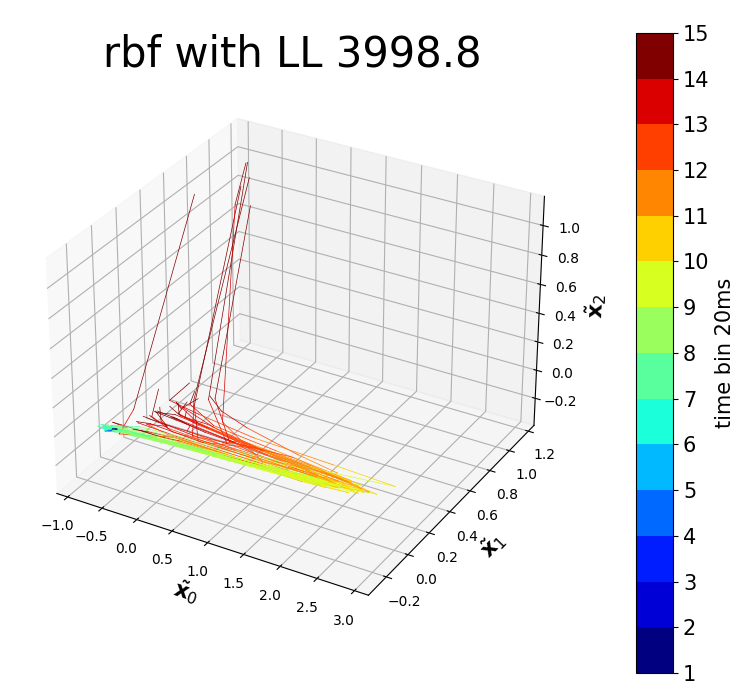

In [19]:
# Unpickle serialized file to reload the stored 3D trajectories
%matplotlib widget
fig_handle = pickle.load(open(fig_path+"/"+fig_name+'_Object.fig.pickle','rb'))

3D latent trajectory extracted by GPFA under spectral mixture kernel, with color gradient emphasizing neuron state.

c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:1092: OptimizeWarning: Initial guess is not within the specified bounds
  res_opt = optimize.minimize(kernel_cost, param_init[i],


Initializing parameters using factor analysis...

Fitting GPFA model...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


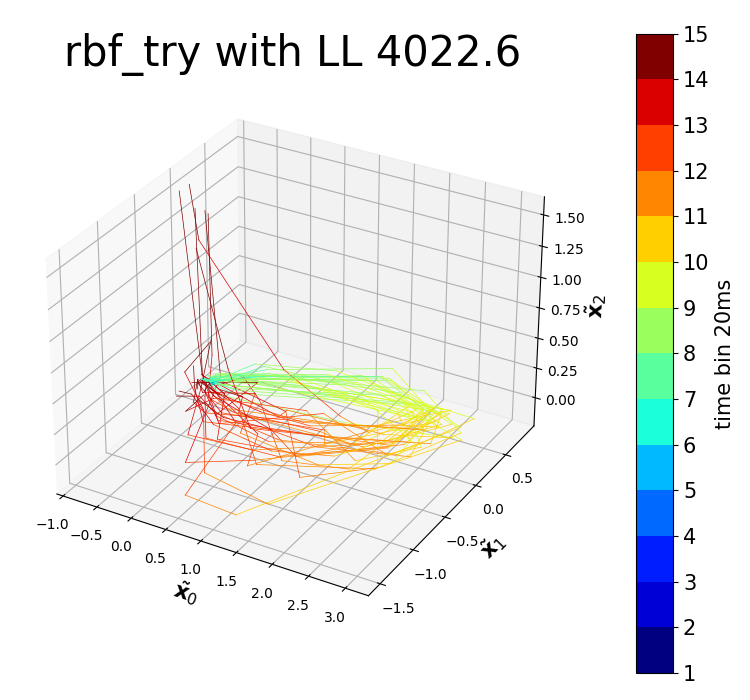

In [20]:
log_likelihood,f,ax1,ax2=plot_trajectories_vs_time(spikeTrains_1,GPFA_kargs = {'x_dim':3, 'bin_size': 20 *pq.ms, 'covType' : 'rbf_try', 'bo': False},
                         dimensions=[0, 1, 2], orthonormalized_dimensions=True, n_trials_to_plot = 30,plot_average=False,gradient_color_bar=False)

Create a 2D data summary of each experiment. Including 2D latent trajectory in `ax1`, latent space dimensions of the first trail versus time in `ax2`, raster plot of spike trains of this experiment in `ax3` and log-likelihood versus dimenions to extract latent trajectories in `ax4`.

In [21]:
def plot_data_summary(spikeTrain_matrix,
                         GPFA_kargs = {'x_dim':2, 'bin_size': 20 *pq.ms, 'covType' : 'rbf', 'bo': False},
                         x_dims = [1,2,3],
                         plot_args_single={'linewidth': 0.5,
                                           'alpha': 1,
                                           'linestyle': '-'},
                         plot_args_average={'linewidth': 2,
                                            'alpha': 1,
                                            'linestyle': '-',
                                            'color' : 'C1'},):
    """
    Plot the 2D latent trajectory (ax1), first and second latent space state dimensions of the first trail versus time (ax2),
    raster plot of spike trains of trail 0 (ax3) and data loglikelihood when extracting latent trajectory to different dimensions (ax4)
    Parameters
    ----------
    spikeTrain_matrix : list of list of neo.SpikeTrain
        Spike train data to be fit to latent variables.
    GPFA_kargs : dict
        Arguments dictionary passed to GPFA
    x_dims : list of int
        Dimensions to analyse GPFA's performance, measured by data log-likelihood
    plot_args_single : dict
        Arguments dictionary passed to ax.plot() of the single trajectories.
    plot_args_average : dict
        Arguments dictionary passed to ax.plot() of the average trajectories.

    Returns
    -------
    loglikelihood : float
        Data log-likelihood using GPFA to extract latent trajectories to 2 dimensions
    f : matplotlib.figure.Figure
    ax1 : matplotlib.axes.Axes
        2D latent trajectory
    ax2 : matplotlib.axes.Axes
        First trail's first and second latent space state dimensions versus time
    ax3 : matplotlib.axes.Axes
        First trail's raster plot of spike trains
    ax4 : matplotlib.axes.Axes
        Data loglikelihood when extracting latent trajectory to different dimensions
    """

    log_likelihoods = []
    log_likelihood = np.nan
    # perform GPFA on every dimension to get data-loglikelihood on different dimensions
    for x_dim in x_dims:
        GPFA_kargs['x_dim'] = x_dim
        gpfa = GPFA(**GPFA_kargs)
        gpfa.fit(spikeTrain_matrix)
        log_likelihood_x_dim = gpfa.fit_info["log_likelihoods"][-1]
        log_likelihoods.append(log_likelihood_x_dim)
        if x_dim == 2:
            log_likelihood = log_likelihood_x_dim
            trajectories = gpfa.transform(spikeTrain_matrix)
            bin_size = gpfa.bin_size

    if 2 not in x_dims:
        GPFA_kargs['x_dim'] = 2
        gpfa = GPFA(**GPFA_kargs)
        log_likelihood_x_dim = gpfa.fit_info["log_likelihoods"][-1]
        log_likelihoods.append(log_likelihood_x_dim)
        trajectories = gpfa.transform(spikeTrain_matrix)
        bin_size = gpfa.bin_size

    lock.acquire()
    f = plt.figure(figsize=(15, 10))
    ax1 = f.add_subplot(2, 2, 1)
    ax2 = f.add_subplot(2, 2, 2)
    ax3 = f.add_subplot(2, 2, 3)
    ax4 = f.add_subplot(2, 2, 4)

    ax1.set_title('Latent dynamics extracted by GPFA with LL '+str(round(log_likelihood,2)))
    ax1.set_xlabel('Dim 1')
    ax1.set_ylabel('Dim 2')
    ax1.set_aspect(1)
    n_trials = trajectories.shape[0]
    for trail_idx in range(n_trials):
        # single trial trajectories
        single_trial_trajectory = trajectories[trail_idx]
        colour_map = np.linspace(0,len(single_trial_trajectory[0]),num=len(single_trial_trajectory[0])-1)
        colour_map_min = colour_map.min()
        colour_map_max = colour_map.max()

        for i in range(len(single_trial_trajectory[0])-1):
                ax1.plot(single_trial_trajectory[0][i:i+2],single_trial_trajectory[1][i:i+2],
                color= plt.cm.jet(int((np.array(colour_map[i])-colour_map_min)*255/(colour_map_max-colour_map_min))),**plot_args_single)

    # trial averaged trajectory
    average_trajectory = np.mean(trajectories, axis=0)
    ax1.plot(average_trajectory[0], average_trajectory[1], **plot_args_average, label='Trial averaged trajectory')
    ax1.legend()

    trial_to_plot = 0
    ax2.set_title(f'Trajectory for trial {trial_to_plot}')
    ax2.set_xlabel('Time [s]')
    times_trajectory = np.arange(len(trajectories[trial_to_plot][0])) * bin_size.rescale('s')
    ax2.plot(times_trajectory, trajectories[0][0], c='C0', label="Dim 1, fitting with all of trials")
    ax2.plot(times_trajectory, trajectories[0][1], c='C1', label="Dim 2, fitting with all of trials")
    ax2.legend()

    trial_to_plot = 0
    ax3.set_title(f'Raster plot of trial {trial_to_plot}')
    ax3.set_xlabel('Time (ms)')
    ax3.set_ylabel('Neuron id')
    # loop through every neuron in the first trail of spikeTrain_matrix
    for i, spiketrain in enumerate(spikeTrain_matrix[trial_to_plot]):
        ax3.plot(spiketrain, np.ones(len(spiketrain)) * i, ls='', marker='|')

    ax4.set_xlabel('Dimensionality of latent variables')
    ax4.set_ylabel('Log-likelihood')
    ax4.plot(x_dims, log_likelihoods, '.-')
    ax4.plot(x_dims[np.argmax(log_likelihoods)], np.max(log_likelihoods), 'x', markersize=10, color='r')
    lock.release()

    plt.tight_layout()
    return log_likelihood,f,ax1,ax2,ax3,ax4

c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '


Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 240 EM iterations.)
w[0]: [0.12445356 0.77940564]
mu[0]: [0.78865978 0.89963472]
vs[0]: [0.11485597 0.03590263]
Initializing parameters using factor analysis...

Fitting GPFA model...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '


Fitting has converged after 440 EM iterations.)
w[0]: [0.92117571 0.14174388]
mu[0]: [0.90281998 0.7730922 ]
vs[0]: [0.02587667 0.09565849]
w[1]: [0.93387182 0.01859643]
mu[1]: [0.90928693 0.41774471]
vs[1]: [0.07133111 0.05638787]
Initializing parameters using factor analysis...

Fitting GPFA model...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '


Fitting has converged after 55 EM iterations.)
w[0]: [0.81055082 0.11413186]
mu[0]: [0.9017236  0.76923429]
vs[0]: [0.02954579 0.10895562]
w[1]: [0.99996097 0.3108784 ]
mu[1]: [0.93420153 0.94985873]
vs[1]: [0.09172046 0.18391319]
w[2]: [0.9511514  0.21316002]
mu[2]: [0.85705842 0.71821112]
vs[2]: [0.04749287 0.06773981]


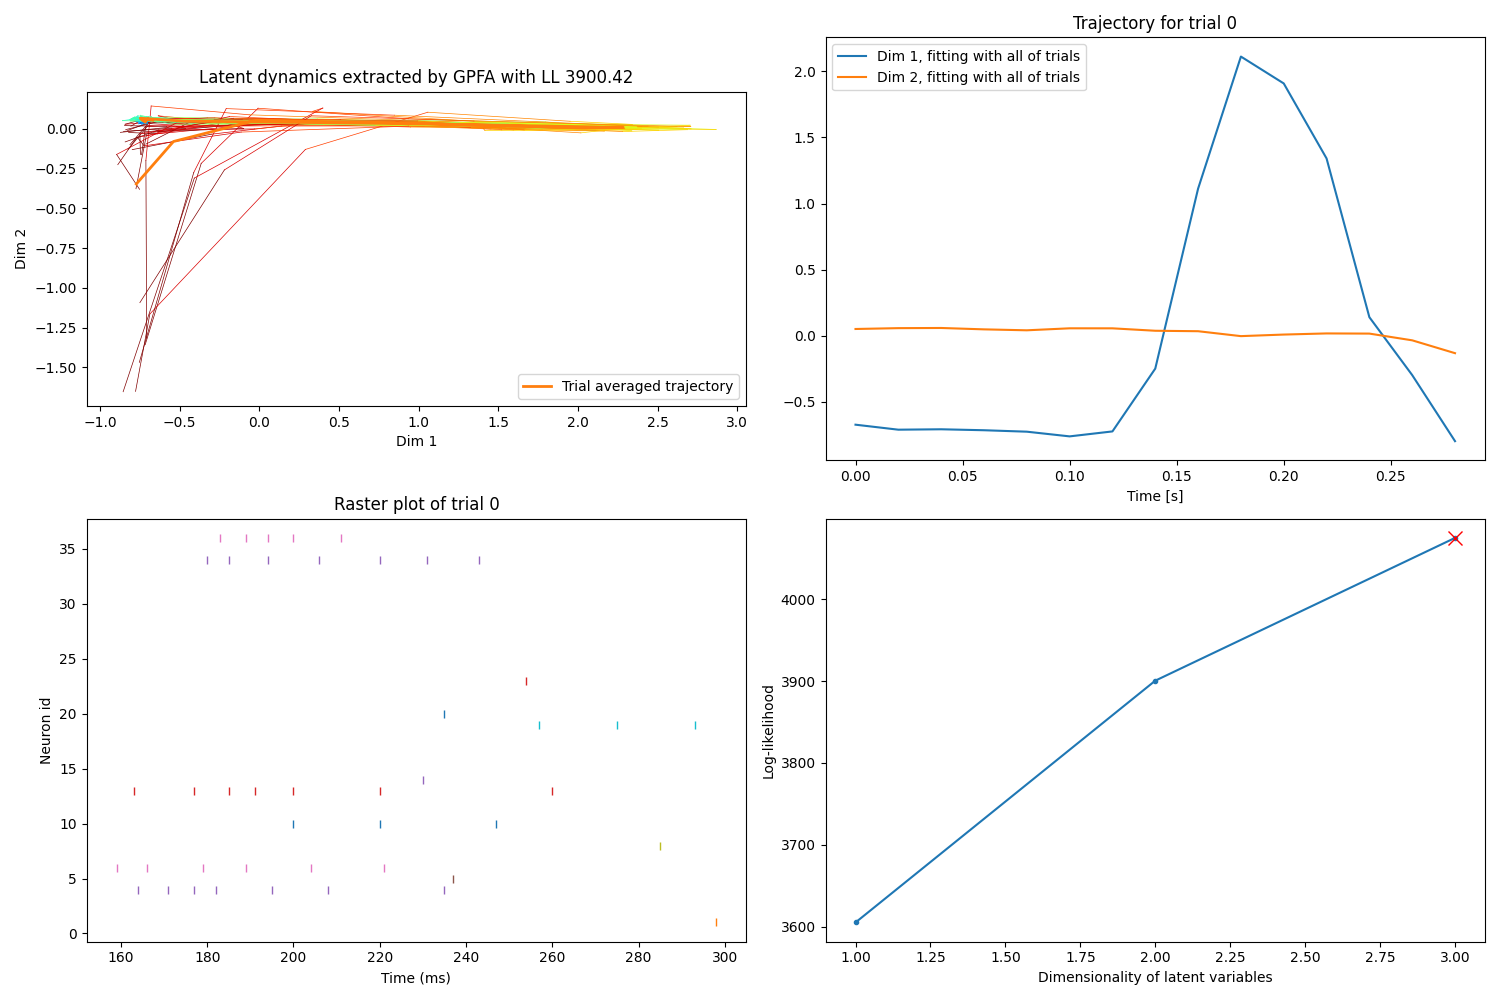

In [22]:
_,_,_,_,_,_ = plot_data_summary(spikeTrains_1,GPFA_kargs = {'x_dim':2, 'bin_size': 20 *pq.ms, 'covType' : 'sm', 'bo': False})

Define a parallel executable function, which plot 2D data summary and 3D latent trajectory of a experiment using GPFA under all types of kernel settings, This function returns a row of dataframe containing data log-likelihood of different kernels under 

In [23]:
def job(spikeTrain_matrix,image_idx,bin_size,bo,figpath):
    """
     Parallel executable task, plot and save the data summary and 3D latent trajectory of spikeTrain_matrix under all types of developed kernels in GPFA.

     Parameters
    ----------
    spikeTrain_matrix : list of list of neo.SpikeTrain
        Spike train data to be fit to latent variables.
    bin_size : float, optional
        spike bin width in msec
    image_idx : int
        index number of spikeTrain_matrix in list_of_Experiments (index number of currently executed spikeTrain_matrix)
     bo: int
        GPFA parameter, number of iterations to tune kernel parameters using Bayesian Optimisation
        using Scipy Powell method instead when set to False
     figpath: str
        Directory to save image results.
        The job will create subdirectories with the name of each kernel and image results are stored in each kernel directory.

    Return
    ------
    loglikelihoods_df : pd.DataFrame
        A row of dataframe storing data log-likelihood running GPFA under all types of kernels when extracting latent trajectory to 2D and 3D
    """

    # log_likelihoods = {'iter':[],'rbf_2d':[],'rbf_3d':[], 'rbf_try_2d':[],'rbf_try_3d':[],'exp_2d':[],'exp_3d':[],'tri_2d':[],'tri_3d':[],
    #            'rq_2d':[],'rq_3d':[],'matern_2d':[],'matern_3d':[],'sm_2d':[],'sm_3d':[],
    #            'tri_times_rq_2d':[],'tri_times_rq_3d':[],'exp_times_rq_2d':[],'exp_times_rq_3d':[],'exp_times_tri_2d':[],'exp_times_tri_3d':[],}
    # kernels = ['rbf','rbf_try','exp','tri','rq','matern','sm','tri_times_rq','exp_times_rq','exp_times_tri']

    log_likelihoods = {'iter':[],'rbf_2d':[],'rbf_3d':[], 'sm_2d':[],'sm_3d':[]}
    kernels = ['rbf','sm']
    log_likelihoods['iter'].append(image_idx)
    for kernel in kernels:
        if not os.path.exists(figpath+'/'+kernel+'/'):
            os.makedirs(figpath+'/'+kernel+'/')
        ll_2d,f,_,_,_,_= plot_data_summary(spikeTrain_matrix,GPFA_kargs = {'x_dim':2, 'bin_size': bin_size *pq.ms, 'covType' : kernel, 'bo': bo})
        f.savefig(figpath+'/'+kernel+'/'+str(image_idx)+'.png')
        plt.close(f)
        ll_3d,f,_,_ = plot_trajectories_vs_time(spikeTrain_matrix,GPFA_kargs = {'x_dim':3, 'bin_size': bin_size *pq.ms, 'covType' : kernel, 'bo': bo})
        f.savefig(figpath+'/'+kernel+'/'+str(image_idx)+'_3d.png')
        pickle_file = open(figpath+'/'+kernel+'/'+str(image_idx)+'_Object.fig.pickle','wb')
        pickle.dump(f,pickle_file)
        pickle_file.close()
        plt.close(f)
        log_likelihoods[kernel+'_2d'] = ll_2d
        log_likelihoods[kernel+'_3d'] = ll_3d


    loglikelihoods_df = pd.DataFrame.from_dict(log_likelihoods)
    return loglikelihoods_df

Loop through all experiments to plot its 2D data summary and 3D Latent Trajectories versus time. Save log-likelihood with different kernels in `loglikelihoods.xlsx` file for kernel performance compairsion.
This is a just a demo of how to run on large neuroscience dataset, running 1 job with all kernels will need hours!

In [24]:
%%time
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import as_completed
warnings.filterwarnings('ignore')
bo = False
bin_size = 20
t_stop = 300
figpath = "./LatentTrajectories/NaturalImages1"
# log_likelihoods = {'iter':[],'rbf_2d':[],'rbf_3d':[], 'rbf_try_2d':[],'rbf_try_3d':[],'exp_2d':[],'exp_3d':[],'tri_2d':[],'tri_3d':[],
#                'rq_2d':[],'rq_3d':[],'matern_2d':[],'matern_3d':[],'sm_2d':[],'sm_3d':[],
#                'tri_times_rq_2d':[],'tri_times_rq_3d':[],'exp_times_rq_2d':[],'exp_times_rq_3d':[],'exp_times_tri_2d':[],'exp_times_tri_3d':[],}
log_likelihoods = {'iter':[],'rbf_2d':[],'rbf_3d':[], 'sm_2d':[],'sm_3d':[]}
               
log_likelihood_df = pd.DataFrame.from_dict(log_likelihoods)
image_idxs = range(0,2)
#
executor = ThreadPoolExecutor(max_workers=2)
all_task = [executor.submit(job,load_spikeTrains(list_of_Experiments[image_idx][0].T,t_stop),image_idx,bin_size,bo,figpath)
            for image_idx in image_idxs]
for future in as_completed(all_task):
    # add try catch for in-sufficient neuroscience data experiment which may cause rank deficient errors
    # try:
    # add 1 row of loglikelihoods to .xlsx file when a experiment finishes execuation will all kernels
    df_at_iter = future.result()
    log_likelihood_df = pd.concat([log_likelihood_df,df_at_iter])
    log_likelihood_df.to_excel(figpath+"/"+figpath.split('/')[2]+"_loglikelihoods.xlsx")
    # except:
    #     pass
log_likelihood_df.sort_values(by=['iter'])
log_likelihood_df = log_likelihood_df.reset_index(drop=True)
log_likelihood_df.to_excel(figpath+"/"+figpath.split('/')[2]+"_loglikelihoods.xlsx")


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '


Initializing parameters using factor analysis...
Initializing parameters using factor analysis...

Fitting GPFA model...

Fitting GPFA model...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '


Fitting has converged after 230 EM iterations.)
Initializing parameters using factor analysis...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '



Fitting GPFA model...
Fitting has converged after 305 EM iterations.)
Initializing parameters using factor analysis...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '



Fitting GPFA model...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '


Initializing parameters using factor analysis...

Fitting GPFA model...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '


Initializing parameters using factor analysis...

Fitting GPFA model...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '


Initializing parameters using factor analysis...

Fitting GPFA model...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '


Initializing parameters using factor analysis...

Fitting GPFA model...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:1092: OptimizeWarning: Initial guess is not within the specified bounds
  res_opt = optimize.minimize(kernel

Initializing parameters using factor analysis...

Fitting GPFA model...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) o

Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 245 EM iterations.)
Initializing parameters using factor analysis...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '



Fitting GPFA model...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:1092: OptimizeWarning: Initial guess is not within the specified bounds
  res_opt = optimize.minimize(kernel_cost, param_init[i],


Fitting has converged after 320 EM iterations.)
Initializing parameters using factor analysis...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '



Fitting GPFA model...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:1092: OptimizeWarning: Initial guess is not within the specified bounds
  res_opt = optimize.minimize(kernel_cost, param_init[i],
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '


Initializing parameters using factor analysis...

Fitting GPFA model...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:1092: OptimizeWarning: Initial guess is not within the specified bounds
  res_opt = optimize.minimize(kernel_cost, param_init[i],
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for trai

Initializing parameters using factor analysis...

Fitting GPFA model...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '


Initializing parameters using factor analysis...

Fitting GPFA model...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:1092: OptimizeWarning: Initial guess is not within the specified bounds
  res_opt = optimize.minimize(kernel_cost, param_init[i],
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:1092: OptimizeWarning: Initial guess is not within the specified bounds
  res_opt = optimize.minimize(kernel_cos

Initializing parameters using factor analysis...

Fitting GPFA model...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) o

Initializing parameters using factor analysis...

Fitting GPFA model...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '


Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 95 EM iterations.)
Initializing parameters using factor analysis...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '



Fitting GPFA model...
Fitting has converged after 50 EM iterations.)
Initializing parameters using factor analysis...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '



Fitting GPFA model...
Fitting has converged after 55 EM iterations.)


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '


Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 90 EM iterations.)


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '


Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 70 EM iterations.)


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '


Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 90 EM iterations.)


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '


Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 70 EM iterations.)


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '


Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 190 EM iterations.)
Initializing parameters using factor analysis...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '



Fitting GPFA model...
Fitting has converged after 90 EM iterations.)


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) o

Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 95 EM iterations.)
Initializing parameters using factor analysis...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '



Fitting GPFA model...
Fitting has converged after 440 EM iterations.)


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '


Initializing parameters using factor analysis...

Fitting GPFA model...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '


Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 375 EM iterations.)


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '


Initializing parameters using factor analysis...

Fitting GPFA model...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '


Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 375 EM iterations.)


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '


Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 90 EM iterations.)
Initializing parameters using factor analysis...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '



Fitting GPFA model...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) o

Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 335 EM iterations.)


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '


Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 145 EM iterations.)
Initializing parameters using factor analysis...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '



Fitting GPFA model...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '


Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 325 EM iterations.)


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '


Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 325 EM iterations.)


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '


Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 350 EM iterations.)
Initializing parameters using factor analysis...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '



Fitting GPFA model...


c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_core.py:106: UserWarning: No segments extracted for training. Defaulting to segLength=Inf.
  warnings.warn('No segments extracted for training. Defaulting to '


Initializing parameters using factor analysis...

Fitting GPFA model...
